# Generative Adverserial Networks (GAN)
<img src="https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fblogs-images.forbes.com%2Fwilliamfalcon%2Ffiles%2F2018%2F10%2Fedmond-de-belamy-framed-cropped.jpg" alt="drawing" width="800"/>

### AI Art at Christie’s Sells for 432,500 US Dollars
https://www.nytimes.com/2018/10/25/arts/design/ai-art-sold-christies.html

### Generative Models

Given training data, train a model that learns the distribution of training data and create new samples from the same distribution.

Discriminative models learn the decision boundary between classes, while the generative models learn the joint propability distribution of classes:

![https://kharshit.github.io/blog/2018/09/28/generative-models-and-generative-adversarial-networks](https://kharshit.github.io/img/discriminative_generative.png)
*Taken from https://kharshit.github.io/blog/2018/09/28/generative-models-and-generative-adversarial-networks*

![](images/overview.png)
*Taken from http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture13.pdf*

## Generative Adverserial Networks (GAN)

2 Networks: 
- Generator: learns to create realistic looking fake images
- Discriminator: learn to distinguish between fake and real (training data)

![](images/gan.png)


![](images/gan_paper.png)
*Taken from https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf*

### Demo GAN Lab
https://poloclub.github.io/ganlab/


### Loss function

Adverserial Loss:

<p style="text-align: center;">
$\min_G \max_D V(D, G)$
</p>

Min Max zero sum game: 
- ideally loss is zero
- GAN will reach the Nash equilibrium between generator and discriminator.


### Convergence

<img src="images/loss.png" alt="drawing" width="1200"/>


### How to avoid unstable training

- Kernel size and filters
- Complexity of Generator
- Don’t mix batch of real and fake images
- Monitor Gradients
- Adding noise
- Feature Matching

### Training
![](https://cdn-images-1.medium.com/max/1280/1*fNGcuJDskQTNoPR_1C12_g.png)

### Uses Cases 

Image Impainting: https://arxiv.org/abs/1607.07539

        
![](images/Image_Impainting1.png)
        

### Use Cases

Deep Convolutional Generative Adverserial Network: https://arxiv.org/abs/1511.06434
![image.png](attachment:image.png)

![](images/DCGAN.png)

### Use Cases 
Superresolution Generative Adverserial Network: https://arxiv.org/abs/1609.04802

![](images/superresolution.png)

### Use Cases

Cycle GAN: https://arxiv.org/abs/1703.10593
<img src="https://junyanz.github.io/CycleGAN/images/teaser_high_res.jpg" alt="drawing" width="1500"/>



#### InfoGAN

https://arxiv.org/abs/1606.03657
- components are deeply entangled
- interpreting components can be difficult


<img src="images/gan1.png" alt="drawing" width="1200"/>


# DC-GAN: Deep Convolutionnal Generative Adversarial Network

[Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434), Alec Radford, Luke Metz, Soumith Chintala, 2016

![](https://cdn-images-1.medium.com/max/960/1*4BYk7IYnhtuq_oM11l-x6w.png)



In [2]:
import glob
import math
import os
import random
import shutil
import zipfile

import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import mxnet.gluon.data.vision.transforms as transforms
import numpy as np
import scipy.misc

## Data

In this lab we are going to use a dataset made of celebrity faces and try to generate new faces that are similar but novel to these faces

In [2]:
dir_name = 'support/gan_images'
filename = mx.test_utils.download('https://s3-us-west-2.amazonaws.com/mxnet-workshop-dropbox/celeba-dataset.zip', dirname='support')
if not os.path.isdir(dir_name):
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall('support/celeba')
    zip_ref = zipfile.ZipFile('support/celeba/img_align_celeba.zip', 'r')
    zip_ref.extractall(dir_name)
    shutil.rmtree('support/celeba')

In [3]:
images = glob.glob(dir_name+'/**/*.jpg')

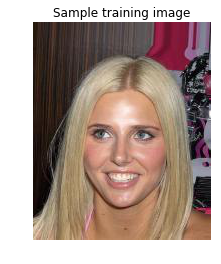

In [4]:
plt.imshow(plt.imread(images[random.randint(0,100)]))
plt.axis('off')
o = plt.title("Sample training image")

### Create a MXNet Dataset

In [5]:
class CelebDataset(gluon.data.Dataset):
    def __init__(self, data_dir, p=0.30):
        """
        data_dir: The rootfolder of the dataset
        p: float [0,1], the proportion of images to use 
        """
        self.img_folder_dataset = gluon.data.vision.ImageFolderDataset(data_dir)
        self.len = int(len(self.img_folder_dataset)*p)

    def __getitem__(self, idx):
        img, _ = self.img_folder_dataset[idx]
        return img 
    
    def __len__(self):
        return self.len

### Data Augmentation

In [6]:
image_size = 64

transform_aug = transforms.Compose(
[
    transforms.Resize(image_size+16, keep_ratio=True),
    transforms.CenterCrop(image_size+16),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
])

In [7]:
dataset = CelebDataset(dir_name).transform(transform_aug)

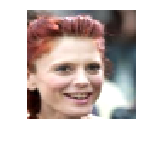

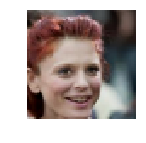

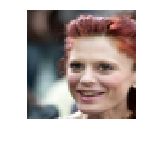

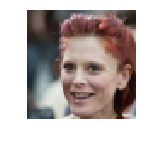

In [8]:
index = random.randint(0,100)
for i in range(4):
    plt.figure(figsize=(2,2))
    plt.imshow(dataset[index].asnumpy())
    plt.axis('off')
    plt.show()

In [ ]:
dataset_tensor = dataset.transform(transforms.ToTensor())
batch_size = 64
train_data = gluon.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True, last_batch='rollover', num_workers=16)

## Network

## Initialize the hyper parameters

In [10]:
ctx = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()

random.seed(1234)
np.random.seed(1234)
mx.random.seed(1234)

## Create the Generator and Discriminator networks

![Generator Photo](https://cdn-images-1.medium.com/max/1600/1*KvMnRfb76DponICrHIbSdg.png)
![Generator and Discriminator Photo](https://gluon.mxnet.io/_images/dcgan.png)
Source: Radford, et al. 2015 (https://arxiv.org/abs/1511.06434)

In [11]:
noise_dimension = 100           # size of the latent z vector (tbe "noise" dimension)
number_channels = 3             # Number of colors (Num input channels)

generator = gluon.nn.HybridSequential()
with generator.name_scope():
    # First layer
    generator.add(gluon.nn.Conv2DTranspose(channels=image_size*8, kernel_size=4, use_bias=False))
    generator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1, center=True))
    generator.add(gluon.nn.Activation('relu'))
    
    # Second layer
    generator.add(gluon.nn.Conv2DTranspose(channels=image_size*4, kernel_size=4, strides = 2, padding=1, use_bias=False))
    generator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1, center=True))
    generator.add(gluon.nn.Activation('relu'))
    generator.add(gluon.nn.Conv2D(channels=image_size*4, kernel_size=3, strides = 1, padding=1, use_bias=False))

    # Third layer
    generator.add(gluon.nn.Conv2DTranspose(channels=image_size*2, kernel_size=4, strides=2,padding=1, use_bias=False))
    generator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1, center=True))
    generator.add(gluon.nn.Activation('relu'))
    generator.add(gluon.nn.Conv2D(channels=image_size*2, kernel_size=3, strides = 1, padding=1, use_bias=True))

    # Fourth layer
    generator.add(gluon.nn.Conv2DTranspose(channels=image_size, kernel_size=4, strides = 2, padding=1, use_bias=False))
    generator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1, center=True))
    generator.add(gluon.nn.Activation('relu'))
    generator.add(gluon.nn.Conv2D(channels=image_size, kernel_size=5, strides = 1, padding=2, use_bias=True))
    generator.add(gluon.nn.Conv2D(channels=image_size, kernel_size=3, strides = 1, padding=1, use_bias=True))
    
    # Fifth layer
    generator.add(gluon.nn.Conv2DTranspose(channels=number_channels, kernel_size=4, strides=2, padding=1, use_bias=False))
    generator.add(gluon.nn.Activation('sigmoid'))

    
    
discriminator = gluon.nn.HybridSequential()
with discriminator.name_scope():
    # First layer
    discriminator.add(gluon.nn.Conv2D(channels=image_size, kernel_size=4, strides=2, padding=1, use_bias=False))
    discriminator.add(gluon.nn.LeakyReLU(0.2))
    
    # Second layer
    discriminator.add(gluon.nn.Conv2D(channels=image_size*2, kernel_size=4, strides=2, padding=1, use_bias=False))
    discriminator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1, center=True))
    discriminator.add(gluon.nn.LeakyReLU(0.2))
    
    # Third layer
    discriminator.add(gluon.nn.Conv2D(channels=image_size*4, kernel_size=4,strides=2,padding=1,use_bias=False))
    discriminator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    discriminator.add(gluon.nn.LeakyReLU(0.2))
    
    # Fourth layer
    discriminator.add(gluon.nn.Conv2D(channels=image_size*8, kernel_size=4, strides=2, padding=1, use_bias=False))
    discriminator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    discriminator.add(gluon.nn.LeakyReLU(0.2))
    
    # Fifth layer
    discriminator.add(gluon.nn.Conv2D(channels=1, kernel_size=4, strides=2, padding=0, use_bias=False))

## A function to visualizing the created and real images

In [12]:
def image_show(data, padding = 2):
    data_np = np.clip(data.asnumpy().transpose((0, 2, 3, 1))*255, 0, 255).astype(np.uint8)
    
    x_dim = min(8, batch_size)
    y_dim = int(math.ceil(float(batch_size) / x_dim))
    height, width = int(image_size + padding), int(image_size + padding)
    grid = np.zeros((height * y_dim + 1 + padding // 2, width * x_dim + 1 + padding // 2,3), dtype = np.uint8)
    k = 0
    for y in range(y_dim):
        for x in range(x_dim):
            if k >= batch_size:
                break
            start_y = y * height + 1 + padding // 2
            end_y = start_y + height - padding 
            start_x = x * width + 1 + padding // 2
            end_x = start_x + width - padding
            np.copyto(grid[start_y:end_y,start_x:end_x,:],data_np[k])
            k = k + 1
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(grid)
    plt.show()

## Initialize the networks and the optimizers

In [13]:
loss_fn = gluon.loss.SigmoidBinaryCrossEntropyLoss()

In [14]:
#Initialization

lr = 0.0001 # learning rate, default=0.0002
beta1 = 0.5 # beta1 for adam
beta2 = 0.999 # beta2 for adam
clip_gradient = 1.0

ctx=mx.gpu() if mx.context.num_gpus() else mx.cpu()

generator.initialize(mx.init.Normal(0.02), ctx=ctx)
generator_trainer = gluon.Trainer(generator.collect_params(), 'Adam', {'learning_rate': lr * 5,'beta1':beta1,'beta2':beta2,'clip_gradient':clip_gradient})

discriminator.initialize(mx.init.Normal(0.02), ctx=ctx)
discriminator_trainer = gluon.Trainer(discriminator.collect_params(), 'Adam', {'learning_rate': lr,'beta1':beta1,'beta2':beta2,'clip_gradient':clip_gradient})

In [15]:
generator.hybridize(static_alloc=True, static_shape=True)
discriminator.hybridize(static_alloc=True, static_shape=True)

## Training Loop

[0/100][948/950] Discriminator loss real: 0.0348 Discriminator loss fake: 0.0294, Generator loss: 0.0101


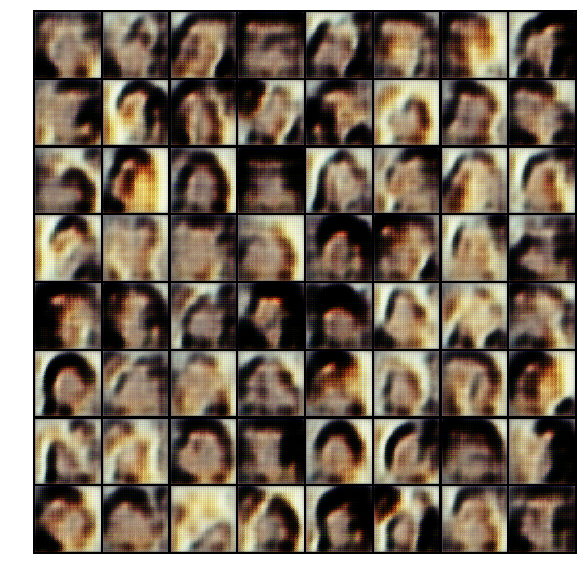

[1/100][949/950] Discriminator loss real: 0.0553 Discriminator loss fake: 0.0292, Generator loss: 0.0143


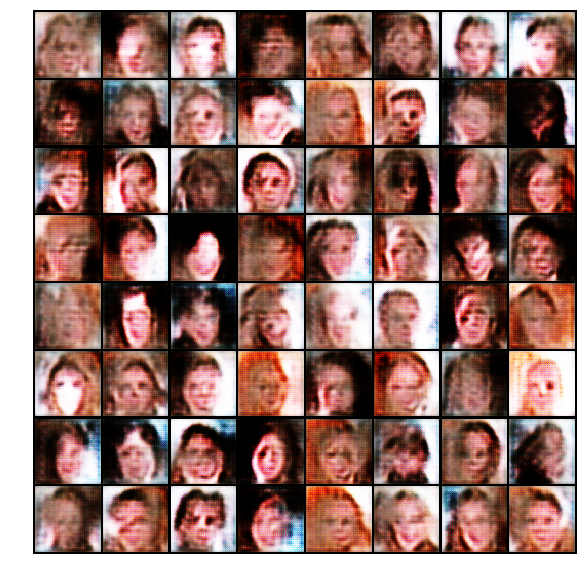

[2/100][949/949] Discriminator loss real: 0.0584 Discriminator loss fake: 0.0271, Generator loss: 0.0265


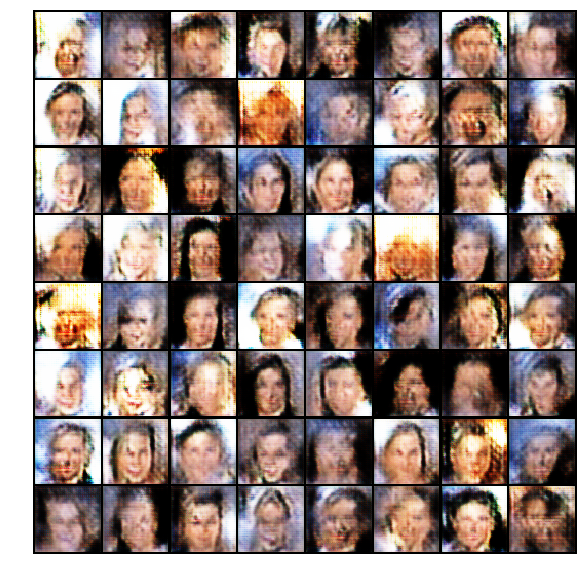

[3/100][948/950] Discriminator loss real: 0.1562 Discriminator loss fake: 0.0652, Generator loss: 0.0239


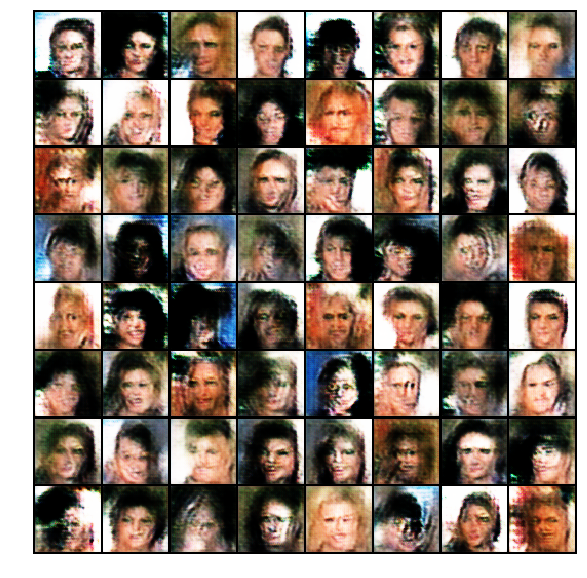

[4/100][949/950] Discriminator loss real: 0.2806 Discriminator loss fake: 0.0702, Generator loss: 0.0401


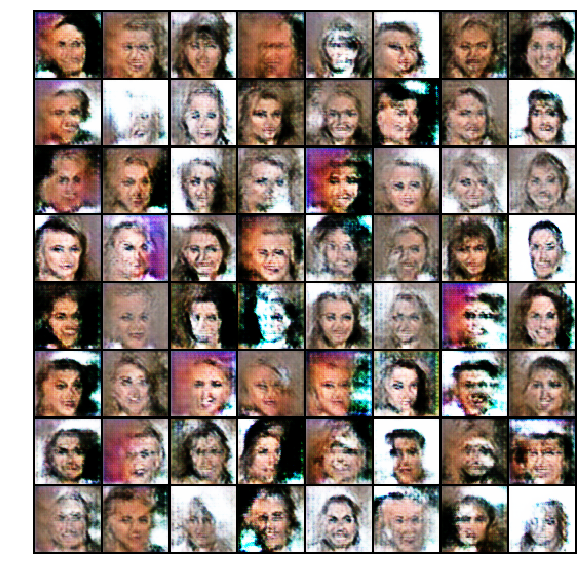

[5/100][949/949] Discriminator loss real: 0.0423 Discriminator loss fake: 0.0312, Generator loss: 0.0261


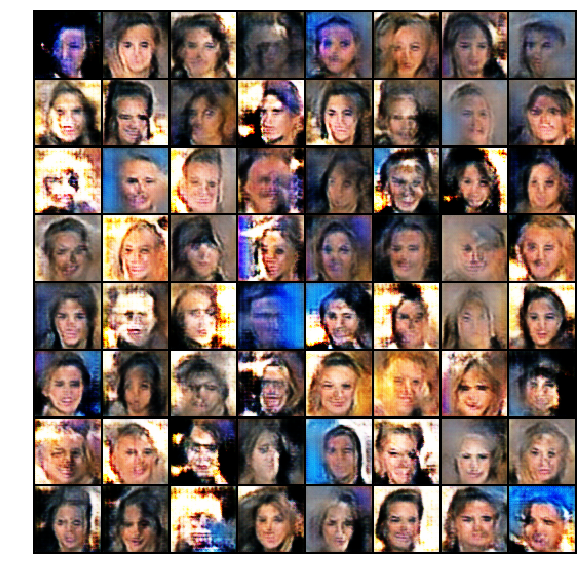

[6/100][948/950] Discriminator loss real: 0.5317 Discriminator loss fake: 0.1559, Generator loss: 0.0297


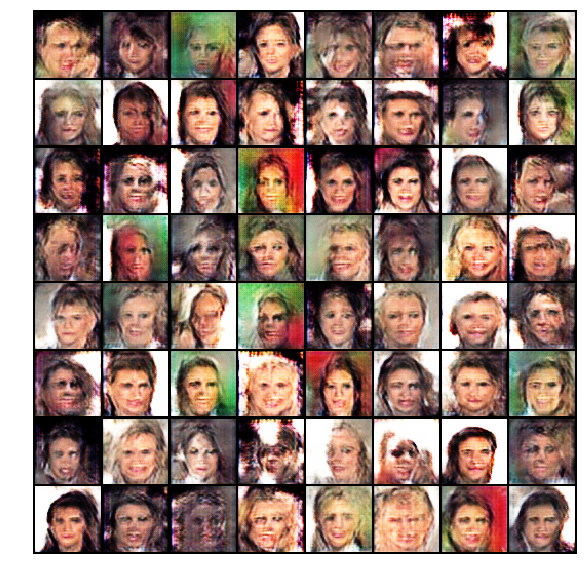

[7/100][949/950] Discriminator loss real: 0.5924 Discriminator loss fake: 0.1233, Generator loss: 0.0494


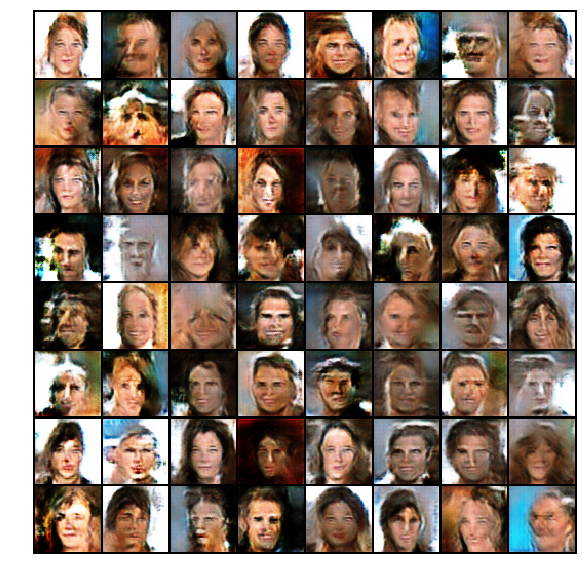

[8/100][949/949] Discriminator loss real: 0.0614 Discriminator loss fake: 0.0451, Generator loss: 0.0192


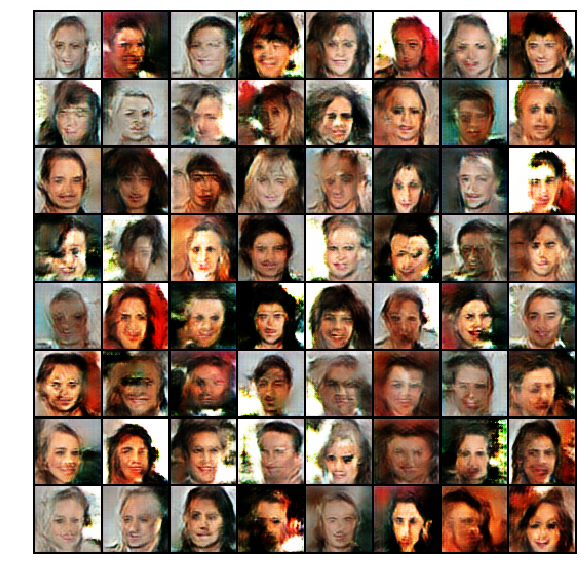

[9/100][948/950] Discriminator loss real: 0.0599 Discriminator loss fake: 0.0277, Generator loss: 0.0179


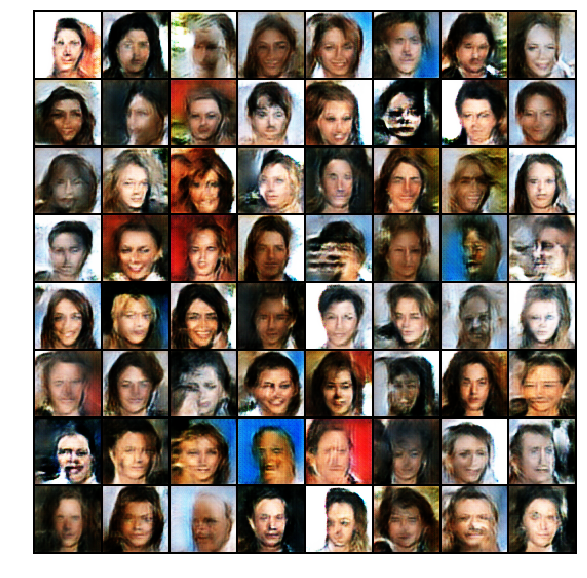

In [16]:
epochs = 100 # number of epochs to train for

for epoch in range(epochs):
    generator_loss_fool = None
    for i, data in enumerate(train_data):
        
        # Update Discriminator
        data_real = data.as_in_context(ctx)
        label_real = nd.ones(batch_size, ctx)
        
        label_fake = nd.zeros(batch_size, ctx)
        generator_noise = nd.normal(loc=0, scale=1, shape=(batch_size, noise_dimension, 1, 1), ctx=ctx)
        
        # Update Discriminator, getting better at guessing real from fake
        with autograd.record():            
            # Pass Real Data through Network
            output = discriminator(data_real)
            
            # Compute the Error on the Real Data
            discriminator_loss_real = loss_fn(output, label_real).mean()
            
            # Pass Noise through the Generator Network to Counterfeits (Fake Images)
            fake_images = generator(generator_noise)
            
            # Pass the fake images through the network and Compute the error
            output = discriminator(fake_images.detach())
            discriminator_loss_fake = loss_fn(output, label_fake).mean()
                       
            # Combine the errors and back-propegate on both
            loss = discriminator_loss_real + discriminator_loss_fake
            
        loss.backward()
        discriminator_trainer.step(batch_size)
        
        gen_step = 0
        while (generator_loss_fool is None or generator_loss_fool > discriminator_loss_fake) and gen_step < 5 :
            # Update Generator, getting better at fooling discriminator!
            with autograd.record():            
                # Pass Noise through the Generator Network to Counterfeits (Fake Images)
                fake_images = generator(generator_noise)

                # Pass the fake images through the network and Compute the error
                output = discriminator(fake_images)
                generator_loss_fool = loss_fn(output, label_real).mean()

            generator_loss_fool.backward()
            generator_trainer.step(batch_size)
            gen_step += 1
        

    print('[%d/%d][%d/%d] Discriminator loss real: %.4f Discriminator loss fake: %.4f, Generator loss: %.4f' % (epoch, epochs, i, len(train_data),
            discriminator_loss_real.asnumpy(), discriminator_loss_fake.asnumpy(), generator_loss_fool.asnumpy()))
    image_show(fake_images)